# *(Brette, et, al., 2007)* COBA-HH

Implementation of the paper:

- Brette, R., Rudolph, M., Carnevale, T., Hines, M., Beeman, D., Bower, J. M., et al. (2007), Simulation of networks of spiking neurons: a review of tools and strategies., J. Comput. Neurosci., 23, 3, 349–98

which is based on the balanced network proposed by:

- Vogels, T. P. and Abbott, L. F. (2005), Signal propagation and logic gating in networks of integrate-and-fire neurons., J. Neurosci., 25, 46, 10786–95




Authors:

- [Chaoming Wang](https://github.com/chaoming0625)


In [1]:
import brainpy as bp
import brainpy.math as bm

bp.math.set_platform('cpu')

## Parameters

In [2]:
num_exc = 3200
num_inh = 800
Cm = 200  # Membrane Capacitance [pF]

gl = 10.  # Leak Conductance   [nS]
g_Na = 20. * 1000
g_Kd = 6. * 1000  # K Conductance      [nS]
El = -60.  # Resting Potential [mV]
ENa = 50.  # reversal potential (Sodium) [mV]
EK = -90.  # reversal potential (Potassium) [mV]
VT = -63.
V_th = -20.

# Time constants
taue = 5.  # Excitatory synaptic time constant [ms]
taui = 10.  # Inhibitory synaptic time constant [ms]

# Reversal potentials
Ee = 0.  # Excitatory reversal potential (mV)
Ei = -80.  # Inhibitory reversal potential (Potassium) [mV]

# excitatory synaptic weight
we = 6.  # excitatory synaptic conductance [nS]

# inhibitory synaptic weight
wi = 67.  # inhibitory synaptic conductance [nS]

## Implementation 1

In [3]:
class HH(bp.NeuGroup):
  def __init__(self, size, method='exp_auto'):
    super(HH, self).__init__(size)

    # variables
    self.V = bm.Variable(El + (bm.random.randn(self.num) * 5 - 5))
    self.m = bm.Variable(bm.zeros(self.num))
    self.n = bm.Variable(bm.zeros(self.num))
    self.h = bm.Variable(bm.zeros(self.num))
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
    self.input = bm.Variable(bm.zeros(size))

    def dV(V, t, m, h, n, Isyn):
      gna = g_Na * (m * m * m) * h
      gkd = g_Kd * (n * n * n * n)
      dVdt = (-gl * (V - El) - gna * (V - ENa) - gkd * (V - EK) + Isyn) / Cm
      return dVdt

    def dm(m, t, V, ):
      m_alpha = 0.32 * (13 - V + VT) / (bm.exp((13 - V + VT) / 4) - 1.)
      m_beta = 0.28 * (V - VT - 40) / (bm.exp((V - VT - 40) / 5) - 1)
      dmdt = (m_alpha * (1 - m) - m_beta * m)
      return dmdt

    def dh(h, t, V):
      h_alpha = 0.128 * bm.exp((17 - V + VT) / 18)
      h_beta = 4. / (1 + bm.exp(-(V - VT - 40) / 5))
      dhdt = (h_alpha * (1 - h) - h_beta * h)
      return dhdt

    def dn(n, t, V):
      c = 15 - V + VT
      n_alpha = 0.032 * c / (bm.exp(c / 5) - 1.)
      n_beta = .5 * bm.exp((10 - V + VT) / 40)
      dndt = (n_alpha * (1 - n) - n_beta * n)
      return dndt

    # functions
    self.integral = bp.odeint(bp.JointEq([dV, dm, dh, dn]), method=method)

  def update(self, tdi):
    V, m, h, n = self.integral(self.V, self.m, self.h, self.n, tdi.t, Isyn=self.input, dt=tdi.dt)
    self.spike.value = bm.logical_and(self.V < V_th, V >= V_th)
    self.m.value = m
    self.h.value = h
    self.n.value = n
    self.V.value = V
    self.input[:] = 0.

In [4]:
class ExpCOBA(bp.TwoEndConn):
  def __init__(self, pre, post, conn, g_max=1., delay=0., tau=8.0, E=0.,
               method='exp_auto'):
    super(ExpCOBA, self).__init__(pre=pre, post=post, conn=conn)
    self.check_pre_attrs('spike')
    self.check_post_attrs('input', 'V')

    # parameters
    self.E = E
    self.tau = tau
    self.delay = delay
    self.g_max = g_max
    self.pre2post = self.conn.require('pre2post')

    # variables
    self.g = bm.Variable(bm.zeros(self.post.num))

    # function
    self.integral = bp.odeint(lambda g, t: -g / self.tau, method=method)

  def update(self, tdi):
    self.g.value = self.integral(self.g, tdi.t, dt=tdi.dt)
    post_sps = bm.pre2post_event_sum(self.pre.spike, self.pre2post, self.post.num, self.g_max)
    self.g.value += post_sps
    self.post.input += self.g * (self.E - self.post.V)

In [5]:
class COBAHH(bp.Network):
  def __init__(self, scale=1., method='exp_auto'):
    num_exc = int(3200 * scale)
    num_inh = int(800 * scale)
    E = HH(num_exc, method=method)
    I = HH(num_inh, method=method)
    E2E = ExpCOBA(pre=E, post=E, conn=bp.conn.FixedProb(prob=0.02),
                  E=Ee, g_max=we / scale, tau=taue, method=method)
    E2I = ExpCOBA(pre=E, post=I, conn=bp.conn.FixedProb(prob=0.02),
                  E=Ee, g_max=we / scale, tau=taue, method=method)
    I2E = ExpCOBA(pre=I, post=E, conn=bp.conn.FixedProb(prob=0.02),
                  E=Ei, g_max=wi / scale, tau=taui, method=method)
    I2I = ExpCOBA(pre=I, post=I, conn=bp.conn.FixedProb(prob=0.02),
                  E=Ei, g_max=wi / scale, tau=taui, method=method)

    super(COBAHH, self).__init__(E2E, E2I, I2I, I2E, E=E, I=I)

In [6]:
net = COBAHH()

In [7]:
runner = bp.DSRunner(net, monitors=['E.spike'])
t = runner.run(100.)

  0%|          | 0/1000 [00:00<?, ?it/s]

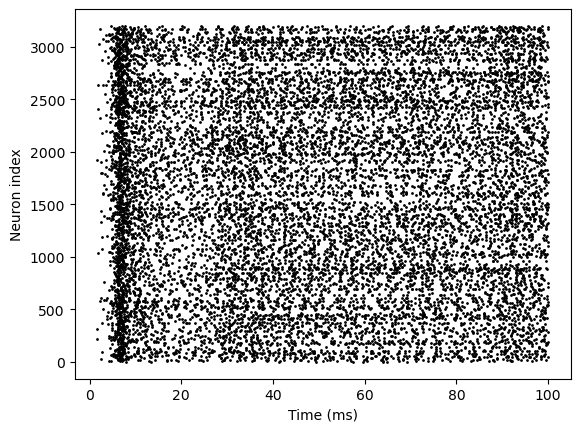

In [8]:
bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'], show=True)

## Implementation 2

In [9]:
class HH2(bp.CondNeuGroup):
  def __init__(self, size):
    super(HH2, self).__init__(size, )
    self.INa = bp.channels.INa_TM1991(size, g_max=100., V_sh=-63.)
    self.IK = bp.channels.IK_TM1991(size, g_max=30., V_sh=-63.)
    self.IL = bp.channels.IL(size, E=-60., g_max=0.05)


In [10]:
class EINet_v2(bp.Network):
  def __init__(self, scale=1.):
    super(EINet_v2, self).__init__()

    prob = 0.02
    self.num_exc = int(3200 * scale)
    self.num_inh = int(800 * scale)

    self.N = HH2(self.num_exc + self.num_inh)
    self.Esyn = bp.synapses.Exponential(self.N[:self.num_exc],
                                        self.N,
                                        bp.conn.FixedProb(prob),
                                        g_max=0.03 / scale, tau=5,
                                        output=bp.synouts.COBA(E=0.))
    self.Isyn = bp.synapses.Exponential(self.N[self.num_exc:],
                                        self.N,
                                        bp.conn.FixedProb(prob),
                                        g_max=0.335 / scale, tau=10.,
                                        output=bp.synouts.COBA(E=-80))

  0%|          | 0/1000 [00:00<?, ?it/s]

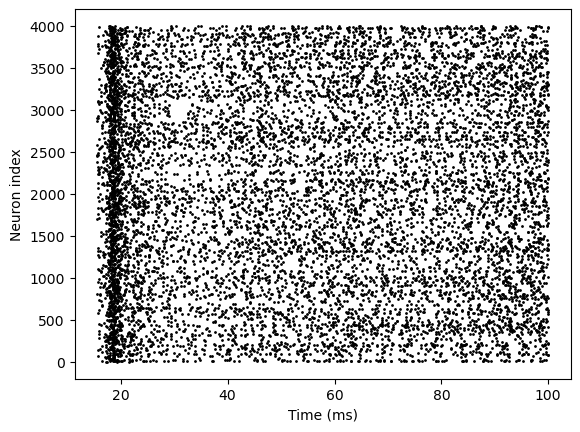

In [11]:
net = EINet_v2(scale=1)
runner = bp.DSRunner(net, monitors={'spikes': net.N.spike})
runner.run(100.)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['spikes'], show=True)